### Mercari Price 
The files consist of a list of product listings. These files are tab-delimited.

Fields:
- train_id or test_id - the id of the listing

- name - the title of the listing. Note that we have cleaned the data to remove text that look like prices (e.g. $20) to avoid  leakage. These removed prices are represented as [rm]

- item_condition_id - the condition of the items provided by the seller

- category_name - category of the listing

- brand_name

- price - the price that the item was sold for. This is the target variable that you will predict. The unit is USD. This column doesn't exist in test.tsv since that is what you will predict.

- shipping - 1 if shipping fee is paid by seller and 0 by buyer

- item_description - the full description of the item. Note that we have cleaned the data to remove text that look like prices (e.g. $20) to avoid leakage. These removed prices are represented as [rm]

In [ ]:
import pandas as pd
import numpy as np

from nltk.tokenize import word_tokenize
import nltk
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow.keras.backend as K


from tqdm._tqdm_notebook import tqdm_notebook

import os
import itertools

import matplotlib.pyplot as plt
import itertools
from collections import Counter
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.layers import Dense, Input, Embedding, Concatenate, Flatten, Dropout, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model 

In [ ]:
tqdm_notebook.pandas()

In [ ]:
#! pip install pydot graphviz

### Dataset download

In [ ]:
# check if in colab
RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    print("Running in colab")
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)
    colab_root = '/content/drive'
    root_dir = "/content/gdrive/My Drive/"
    base_dir = root_dir + 'project-mercari-price/'
    if not os.path.isdir(base_dir):
        os.mkdir(base_dir)
else:
    root_dir= os.getcwd()
    base_dir = root_dir
    
os.chdir(base_dir)

Running in colab
Mounted at /content/gdrive


In [ ]:
dataset_downloaded_path = os.path.join(base_dir, "dataset_downloaded.ignore")
dataset_downloaded = os.path.isfile(dataset_downloaded_path)
dataset_downloaded

True

In [ ]:
if not dataset_downloaded:
  # install kaggle to download dataset
  ! pip install kaggle python-dotenv

In [ ]:
# set to True if you want to save kaggle credentials into a .env file
persist_credentials = False

if not dataset_downloaded:
  # create .env file containing KAGGLE_USER and KAGGLE_KEY
    kaggle_env = os.path.join(base_dir, '.env')
    if not os.path.isfile(kaggle_env):
        with open(kaggle_env, 'w') as envfile:
            kaggle_user = input("Insert kaggle username")
            kaggle_key = input("Insert kaggle key; generate one from kaggle account")
        if persist_credentials:
            envfile.write(f"""
            KAGGLE_USERNAME={kaggle_user}
            KAGGLE_KEY={kaggle_key}
            """)

        # set env vars
        os.environ["KAGGLE_USERNAME"] = kaggle_user
        os.environ["KAGGLE_KEY"] = kaggle_key

        del kaggle_user
        del kaggle_key

In [ ]:
if not dataset_downloaded:
  # loading env vars if .env file exists
    if os.path.isfile(kaggle_env):
        from dotenv import load_dotenv
        load_dotenv(dotenv_path=kaggle_env)
    print(os.environ.get("KAGGLE_USERNAME"))

In [ ]:
if not dataset_downloaded:
    # download and extract dataset
    ! kaggle competitions download -c mercari-price-suggestion-challenge

    # create file so that we know we already downloaded
    with open(dataset_downloaded_path, 'w') as dd_file:
        dataset_downloaded = True
        dd_file.write("")

    print('cwd: ', os.getcwd())
    
    os.listdir()

In [ ]:
if not dataset_downloaded:
    ! 7z x train.tsv.7z
    ! 7z x test.tsv.7z

In [ ]:
os.listdir()

['train.tsv',
 'test.tsv',
 '.env',
 'sample_submission.csv.7z',
 'test_stg2.tsv.zip',
 'train.tsv.7z',
 'test.tsv.7z',
 'sample_submission_stg2.csv.zip',
 'dataset_downloaded',
 '.git',
 '.gitignore',
 'Notebook.Rmd',
 'Readme.md',
 'requirements.txt',
 'Untitled.ipynb',
 'git',
 'dataset_downloaded.ignore',
 'model.png']

## Load dataset

In [ ]:
dtypes={
    'name': 'string',
    'item_condition_id': 'int32',
    'category_name': 'string',
    'brand_name': 'string',
    'price': 'float',
    'shipping': 'int32',
    'item_description': 'string'
}
data = pd.read_csv("train.tsv", sep='\t', dtype=dtypes)
data = data.drop(columns=["train_id"])
data

,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,<NA>,10.0,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,<NA>,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,<NA>,44.0,0,Complete with certificate of authenticity
...,...,...,...,...,...,...,...
1482530,Free People Inspired Dress,2,Women/Dresses/Mid-Calf,Free People,20.0,1,"Lace, says size small but fits medium perfectl..."
1482531,Little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,14.0,0,Little mermaid handmade dress never worn size 2t
1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,<NA>,12.0,0,"Used once or twice, still in great shape."
1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,<NA>,45.0,1,There is 2 of each one that you see! So 2 red ...


In [ ]:
data.dtypes

name                  string
item_condition_id      int32
category_name         string
brand_name            string
price                float64
shipping               int32
item_description      string
dtype: object

In [ ]:
data.shape

(1482535, 7)

In [ ]:
for column in data.columns:
    print("number of null value in {} : {}".format(column,data[column].isnull().sum()))

number of null value in name : 0
number of null value in item_condition_id : 0
number of null value in category_name : 6327
number of null value in brand_name : 632682
number of null value in price : 0
number of null value in shipping : 0
number of null value in item_description : 4


In [ ]:
data["category_name"].value_counts()

Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
                                                  ...  
Vintage & Collectibles/Book/Decorating                1
Handmade/Knitting/Bags and Purses                     1
Handmade/Toys/Bear                                    1
Handmade/Woodworking/Supplies                         1
Handmade/Weddings/Frames                              1
Name: category_name, Length: 1287, dtype: Int64

In [ ]:
data["price"].describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

In [ ]:
data = data[data["item_description"].notna()]
data["brand_name"] = data["brand_name"].fillna(value="NA")
data["category_name"] = data["category_name"].fillna(value="NA")
# see warnings -> inplace?
data.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(1482531, 7)

In [ ]:
def flat_list(l):
    return  [item for sublist in l for item in sublist]


def plot_common_tokens(tokens, title, n=20):
    sentences = (list(itertools.chain(tokens)))
    flat_sentences = flat_list(sentences)
    counts = Counter(flat_sentences)
    #print(counts.most_common(30))
    common_words = [word[0] for word in counts.most_common(n)]
    common_counts = [word[1] for word in counts.most_common(n)]
    fig = plt.figure(figsize=(18,6))
    sns.barplot(x=common_words, y=common_counts)
    plt.title(title)
    plt.show()


In [ ]:
#plot_common_tokens(data["item_description_tokens"], "Most Common Tokens from Descriptions")

In [ ]:
data

,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NA,10.0,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NA,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NA,44.0,0,Complete with certificate of authenticity
...,...,...,...,...,...,...,...
1482530,Free People Inspired Dress,2,Women/Dresses/Mid-Calf,Free People,20.0,1,"Lace, says size small but fits medium perfectl..."
1482531,Little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,14.0,0,Little mermaid handmade dress never worn size 2t
1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,NA,12.0,0,"Used once or twice, still in great shape."
1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,NA,45.0,1,There is 2 of each one that you see! So 2 red ...


In [ ]:
class LabelEncoder:
  def __init__(self, unknown = 0, invUnknown = 'unknown'):
    self.leDict = {}
    self.invDict = {}
    self.unknown = unknown
    self.invUnknown = invUnknown

  def fit(self, data):
    vci = data.value_counts().index
    self.leDict = dict(zip(vci, range(1, len(vci))))
    self.invDict = dict(zip(range(1, len(vci)), vci))

  def transform1(self, item):
    return self.leDict.get(item, self.unknown)

  def transform(self, data):
    return data.apply(lambda item: self.transform1(item))

  def inverse_transform1(self, item):
    return self.invDict.get(item, self.invUnknown)

  def inverse_transform(self, data):
    return data.apply(lambda item: self.inverse_transform1(item))

In [ ]:
cat_le = LabelEncoder()
cat_le.fit(data["category_name"])

data["category_name_l"] = cat_le.transform(data["category_name"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
brand_le = LabelEncoder()
brand_le.fit(data["brand_name"])

data["brand_name_l"] = brand_le.transform(data["brand_name"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
def getTokens(data, tokenizer=None, dataFit=None, num_words=5000):
    if dataFit is None:
        dataFit = data
        
    if tokenizer is None:
        tokenizer = Tokenizer(num_words=num_words)
        tokenizer.fit_on_texts(dataFit)
    
    tokens = tokenizer.texts_to_sequences(data)
    return tokens, tokenizer

In [ ]:
data["item_description"]=data["item_description"].str.lower()
data["name"]=data["name"].str.lower()
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_name_l,brand_name_l
0,mlb cincinnati reds t shirt size xl,3,Men/Tops/T-shirts,NA,10.0,1,no description yet,19,1
1,razer blackwidow chroma keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,this keyboard is in great condition and works ...,242,585
2,ava-viv blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,adorable top with a hint of lace and a key hol...,9,82
3,leather horse statues,1,Home/Home Décor/Home Décor Accents,NA,35.0,1,new with tags. leather horses. retail for [rm]...,28,1
4,24k gold plated rose,1,Women/Jewelry/Necklaces,NA,44.0,0,complete with certificate of authenticity,12,1


In [ ]:
tokenizer = Tokenizer(num_words=5000)

texts = np.hstack([data["item_description"], data["name"]])
tokenizer.fit_on_texts(texts)

data["item_description_t"]=tokenizer.texts_to_sequences(data["item_description"])
data["name_t"]=tokenizer.texts_to_sequences(data["name"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
data

,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_name_l,brand_name_l,item_description_t,name_t
0,mlb cincinnati reds t shirt size xl,3,Men/Tops/T-shirts,NA,10.0,1,no description yet,19,1,"[12, 68, 79]","[3852, 208, 84, 6, 155]"
1,razer blackwidow chroma keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,this keyboard is in great condition and works ...,242,585,"[29, 2627, 10, 7, 39, 17, 1, 207, 51, 19, 1113...",[2627]
2,ava-viv blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,adorable top with a hint of lace and a key hol...,9,82,"[604, 60, 9, 4, 11, 192, 1, 4, 886, 1290, 7, 2...",[666]
3,leather horse statues,1,Home/Home Décor/Home Décor Accents,NA,35.0,1,new with tags. leather horses. retail for [rm]...,28,1,"[5, 9, 61, 178, 230, 3, 21, 166, 1085, 222, 4,...","[178, 2610]"
4,24k gold plated rose,1,Women/Jewelry/Necklaces,NA,44.0,0,complete with certificate of authenticity,12,1,"[807, 9, 11, 1997]","[4884, 104, 1032, 280]"
...,...,...,...,...,...,...,...,...,...,...,...
1482530,free people inspired dress,2,Women/Dresses/Mid-Calf,Free People,20.0,1,"lace, says size small but fits medium perfectl...",247,46,"[192, 690, 6, 44, 38, 160, 69, 710, 165, 36, 3...","[13, 573, 1667, 82]"
1482531,little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,14.0,0,little mermaid handmade dress never worn size 2t,126,15,"[156, 1321, 693, 82, 36, 30, 6, 1000]","[156, 1321, 693, 82]"
1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,NA,12.0,0,"used once or twice, still in great shape.",86,1,"[31, 96, 23, 356, 121, 7, 39, 385]","[293, 117, 1526, 2496, 1, 3693]"
1482533,world markets lanterns,3,Home/Home Décor/Home Décor Accents,NA,45.0,1,there is 2 of each one that you see! so 2 red ...,28,1,"[240, 10, 22, 11, 166, 46, 78, 18, 138, 76, 22...",[1370]


In [ ]:
final_data=data[["item_condition_id","shipping","category_name_l","brand_name_l", "item_description_t", "name_t", "price"]]
final_data

,item_condition_id,shipping,category_name_l,brand_name_l,item_description_t,name_t,price
0,3,1,19,1,"[12, 68, 79]","[3852, 208, 84, 6, 155]",10.0
1,3,0,242,585,"[29, 2627, 10, 7, 39, 17, 1, 207, 51, 19, 1113...",[2627],52.0
2,1,1,9,82,"[604, 60, 9, 4, 11, 192, 1, 4, 886, 1290, 7, 2...",[666],10.0
3,1,1,28,1,"[5, 9, 61, 178, 230, 3, 21, 166, 1085, 222, 4,...","[178, 2610]",35.0
4,1,0,12,1,"[807, 9, 11, 1997]","[4884, 104, 1032, 280]",44.0
...,...,...,...,...,...,...,...
1482530,2,1,247,46,"[192, 690, 6, 44, 38, 160, 69, 710, 165, 36, 3...","[13, 573, 1667, 82]",20.0
1482531,2,0,126,15,"[156, 1321, 693, 82, 36, 30, 6, 1000]","[156, 1321, 693, 82]",14.0
1482532,2,0,86,1,"[31, 96, 23, 356, 121, 7, 39, 385]","[293, 117, 1526, 2496, 1, 3693]",12.0
1482533,3,1,28,1,"[240, 10, 22, 11, 166, 46, 78, 18, 138, 76, 22...",[1370],45.0


In [ ]:
train, validation = train_test_split(final_data, test_size=0.2, random_state=1000)

In [ ]:
'''X = data[['name', 'item_condition_id', 'category_name', 'brand_name',
       'shipping','item_description']]
y = data['price']'''

In [ ]:
'''X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1000)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=1000)'''

In [ ]:
#tokenizers = {}

In [ ]:
#X_train["item_description_t"], tokenizers["item_description"] = getTokens(X_train["item_description"])
#X_train["name_t"], tokenizers["name"] = getTokens(X_train["name"])

In [ ]:
#X_validation["item_description_t"], _ = getTokens(X_validation["item_description"], tokenizer=tokenizers["item_description"])
#X_validation["name_t"], _ = getTokens(X_validation["name"], tokenizer=tokenizers["name"])

In [ ]:
#tokenizers

{'item_description': <keras_preprocessing.text.Tokenizer at 0x7f2734683828>,
 'name': <keras_preprocessing.text.Tokenizer at 0x7f27358e7128>}

In [ ]:
#X_train["item_description_t"]

995196     [6, 5, 144, 279, 173, 979, 84, 135, 173, 657, ...
28823      [685, 1020, 340, 78, 306, 50, 6, 281, 90, 2526...
661855     [27, 17, 136, 170, 194, 1102, 613, 188, 759, 6...
733730     [5, 444, 1202, 99, 16, 86, 177, 16, 12, 165, 1...
807837     [27, 106, 497, 11, 435, 117, 235, 4571, 682, 2...
                                 ...                        
371719                              [9, 83, 232, 35, 32, 26]
1311257    [3867, 3867, 2095, 23, 3, 146, 3928, 2, 1827, ...
404942                     [6, 49, 540, 167, 41, 1340, 1878]
242521     [200, 128, 69, 2977, 124, 234, 362, 96, 133, 9...
371320     [2, 1450, 761, 2116, 5, 10, 3, 153, 494, 494, ...
Name: item_description_t, Length: 889518, dtype: object

In [ ]:
#X_validation["category_name_l"] = cat_le.transform(X_validation["category_name"])

In [ ]:
#X_validation["brand_name_l"] = brand_le.transform(X_validation["brand_name"])

In [ ]:
#len(tokenizers["item_description"].word_index)

In [ ]:
# unknown values !!! now -> crash

In [ ]:
#X_train.loc[995196, ["name", "name_t"]]

name      PINK❤️warm and cozy mist/lotion set
name_t                [9, 1995, 431, 288, 17]
Name: 995196, dtype: object

In [ ]:
#X_train.head()

,name,item_condition_id,category_name,brand_name,shipping,item_description,item_description_t,name_t,category_name_l,brand_name_l
995196,PINK❤️warm and cozy mist/lotion set,1,Beauty/Fragrance/Women,Victoria's Secret,0,New in original packaging -Body mist 250ml/8.4...,"[6, 5, 144, 279, 173, 979, 84, 135, 173, 657, ...","[9, 1995, 431, 288, 17]",16,4
28823,18 min vest,3,Kids/Girls 0-24 Mos/One-Pieces,NA,1,Faux fur zipper up best like new Purchased at ...,"[685, 1020, 340, 78, 306, 50, 6, 281, 90, 2526...","[234, 276]",68,1
661855,Artsy stylish leather purse & pouch,3,Handmade/Bags and Purses/Purse,NA,0,Used condition cowhide high quality leather!! ...,"[27, 17, 136, 170, 194, 1102, 613, 188, 759, 6...","[3172, 118, 83, 922]",189,1
733730,Decor pillows,2,Home/Home Décor/Decorative Pillows,NA,0,In mint conditions Smoke free home Pet free No...,"[5, 444, 1202, 99, 16, 86, 177, 16, 12, 165, 1...","[599, 2390]",261,1
807837,IF NOT SOLD DONATING 2/6,4,Men/Shoes/Outdoor,Oakley,0,Used still lots of life...see pictures...Oakle...,"[27, 106, 497, 11, 435, 117, 235, 4571, 682, 2...","[4155, 630, 1029, 11, 20]",732,172


In [ ]:
'''desc_vocab_size = len(t['item_description'].word_index) + 1
print(desc_vocab_size)

name_vocab_size = len(t['name'].word_index) + 1
print(name_vocab_size)'''
vocab_size= len(tokenizer.word_index)+1
print(vocab_size)

259088


In [ ]:
#X_train["item_description_t"]

995196     [6, 5, 144, 279, 173, 979, 84, 135, 173, 657, ...
28823      [685, 1020, 340, 78, 306, 50, 6, 281, 90, 2526...
661855     [27, 17, 136, 170, 194, 1102, 613, 188, 759, 6...
733730     [5, 444, 1202, 99, 16, 86, 177, 16, 12, 165, 1...
807837     [27, 106, 497, 11, 435, 117, 235, 4571, 682, 2...
                                 ...                        
371719                              [9, 83, 232, 35, 32, 26]
1311257    [3867, 3867, 2095, 23, 3, 146, 3928, 2, 1827, ...
404942                     [6, 49, 540, 167, 41, 1340, 1878]
242521     [200, 128, 69, 2977, 124, 234, 362, 96, 133, 9...
371320     [2, 1450, 761, 2116, 5, 10, 3, 153, 494, 494, ...
Name: item_description_t, Length: 889518, dtype: object

In [ ]:
def lengthCumDistribution(data, threshold=0.8):
  lengths = data.apply(lambda x: len(x))
  lengthsHist = lengths.hist
  lengthsFreq = lengths.value_counts().sort_index()
  lengthsFreqNormalized = lengthsFreq / sum(lengthsFreq)
  lengthsCumFreq = lengthsFreqNormalized.cumsum()

  index = lengthsCumFreq.where(lengthsCumFreq >= threshold).first_valid_index()

  cumPlot = lengthsCumFreq.plot

  return index, lengthsCumFreq, cumPlot, lengthsHist

name length max 6


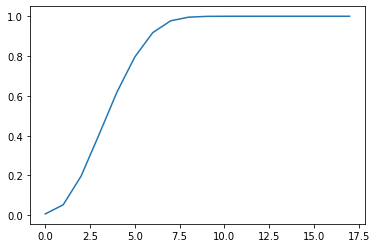

In [ ]:
name_length_max, name_length_distr, name_length_dplot, name_length_hist = lengthCumDistribution(X_train["name_t"])
print('name length max', name_length_max)
name_length_dplot()

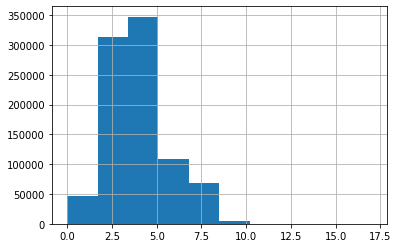

In [ ]:
name_length_hist()

name length max 35


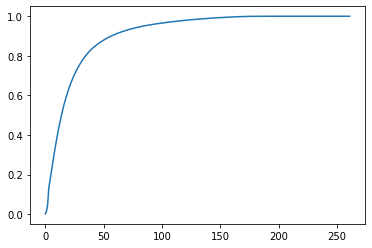

In [ ]:
desc_length_max, desc_length_distr, desc_length_dplot, desc_length_hist = lengthCumDistribution(X_train["item_description_t"])
print('name length max', desc_length_max)
desc_length_dplot()

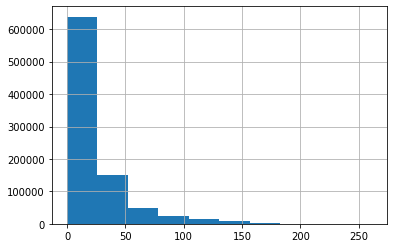

In [ ]:
desc_length_hist()

In [ ]:
train[["item_description_t","name_t"]]

,item_description_t,name_t
1095625,315,"[553, 569, 791, 101]"
633753,36,"[105, 1653]"
1397300,200,"[480, 512]"
417395,875,"[875, 823, 2222]"
34778,12,"[1175, 1611, 259, 303, 256]"
...,...,...
18782,24,"[283, 2226]"
376059,56,"[3786, 2040, 1022]"
134848,235,"[134, 2956, 174, 24, 2350, 244, 1264]"
1120329,230,"[230, 21, 1392]"


In [ ]:
desc_length_max=75
inputDesc_train = pad_sequences(train["item_description_t"],
                                                  padding='post', maxlen=desc_length_max)

In [ ]:
inputDesc_validation = pad_sequences(validation["item_description_t"],
                                                  padding='post', maxlen=desc_length_max)

In [ ]:
name_length_max=10
inputName_train = pad_sequences(train["name_t"], padding='post', maxlen=name_length_max)

In [ ]:
inputName_validation = pad_sequences(validation["name_t"], padding='post', maxlen=name_length_max)

In [ ]:
y_train = train["price"]
y_train

1095625    35.0
633753     13.0
1397300    16.0
417395     38.0
34778      74.0
           ... 
18782      12.0
376059      6.0
134848     23.0
1120329    25.0
1156533     6.0
Name: price, Length: 1186024, dtype: float64

In [ ]:
y_validation = validation["price"]
y_validation

197599      19.0
678463       9.0
630578     116.0
470176      16.0
1183785     13.0
           ...  
856621      12.0
178114      13.0
496647       4.0
938510      18.0
919189      25.0
Name: price, Length: 296507, dtype: float64

In [ ]:
class MeanStdScaler:
  def __init__(self):
    self.mean = 0
    self.std = 1

  def fit(self, data):
    self.mean = np.mean(data)
    self.std = np.std(data)

  def transform(self, data):
    return (data - self.mean) / self.std

  def inverse_transform(self, data):
    return (data * self.std) + self.mean

In [ ]:
y_scaler = MeanStdScaler()
y_scaler.fit(y_train)

In [ ]:
y_train = y_scaler.transform(y_train)
y_validation = y_scaler.transform(y_validation)

In [ ]:
X_train[["item_condition_id", "category_name_l", "brand_name_l", "shipping"]]

,item_condition_id,category_name_l,brand_name_l,shipping
995196,1,16,4,0
28823,3,68,1,1
661855,3,189,1,0
733730,2,261,1,0
807837,4,732,172,0
...,...,...,...,...
371719,2,435,58,0
1311257,1,31,208,0
404942,1,4,1,0
242521,2,127,4,1


In [ ]:
train.head()

,item_condition_id,shipping,category_name_l,brand_name_l,item_description_t,name_t,price
1095625,1,1,18,30,"[315, 791, 733, 24, 1, 59, 101]","[553, 569, 791, 101]",35.0
633753,2,0,165,4,"[36, 30, 4935, 15, 667, 119, 6, 69]","[105, 1653]",13.0
1397300,3,1,138,37,"[200, 155, 118, 939, 1, 219, 1, 193, 66, 731, ...","[480, 512]",16.0
417395,2,0,23,32,"[875, 823, 4114, 2222, 9, 104, 1056, 7, 51, 5,...","[875, 823, 2222]",38.0
34778,3,0,17,877,"[12, 68, 79]","[1175, 1611, 259, 303, 256]",74.0


In [ ]:
inputA_train = train[["item_condition_id", "category_name_l", "brand_name_l", "shipping"]].values.astype('int32')

In [ ]:
inputA_validation = validation[["item_condition_id", "category_name_l", "brand_name_l", "shipping"]].values.astype('int32')

In [ ]:
msle = tf.keras.losses.MeanSquaredLogarithmicError()
mae = tf.keras.losses.MeanAbsoluteError()

# sclb stands for scaled back

def root_mean_squared_logarithmic_error_sclb(y_true, y_pred):
  y_true = y_scaler.inverse_transform(y_true)
  y_pred = y_scaler.inverse_transform(y_pred)
  return K.sqrt(msle(y_true, y_pred))

def mae_sclb(y_true, y_pred):
  y_true = y_scaler.inverse_transform(y_true)
  y_pred = y_scaler.inverse_transform(y_pred)

  return mae(y_true, y_pred)


In [ ]:
name_vocab_size=vocab_size
desc_vocab_size=vocab_size
def getModel():
    inputA = Input(shape=(4,))
    #Ad = Dense(4, activation='relu')(inputA)
    Ad = inputA
    
    inputName = Input(shape=(name_length_max,))
    Ne = Embedding(input_dim=name_vocab_size, output_dim=8, input_length=name_length_max)(inputName)
    Nd = LSTM(8,return_sequences=True)(Ne)
    Nd = Flatten()(Nd)

    #Nd = Nf
    
    inputDesc = Input(shape=(desc_length_max,))
    De = Embedding(input_dim=desc_vocab_size, output_dim=16, input_length=desc_length_max)(inputDesc)
    Dd = LSTM(16,return_sequences=True)(De)
    Dd = Flatten()(Dd)
    #Dd = Df
    
    concat = Concatenate()([Ad, Nd, Dd])

    x = Dropout(0.1)(concat)    
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(1, activation='linear')(x)
    
    model = Model(inputs=[inputA, inputName, inputDesc], outputs=x)
    
    return model
    

In [ ]:
model = getModel()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 75)]         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 10, 8)        2072704     input_13[0][0]                   
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 75, 16)       4145408     input_14[0][0]                   
_______________________________________________________________________________________

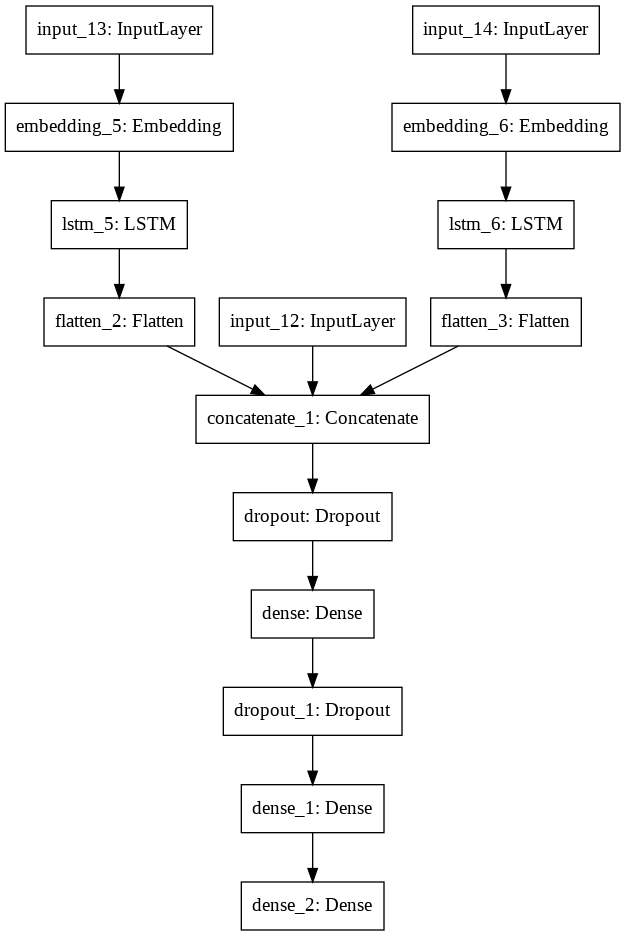

In [ ]:
plot_model(model)

In [ ]:
import keras.backend as K
msle = tf.keras.losses.MeanSquaredLogarithmicError()

def root_mean_squared_logarithmic_error(y_true, y_pred):
    return K.sqrt(msle(y_true, y_pred))

In [ ]:
model.compile(loss = 'mse', optimizer='adam', metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError(), 'mean_squared_logarithmic_error', root_mean_squared_logarithmic_error])

In [ ]:
history = model.fit(x=[inputA_train, inputName_train, inputDesc_train], y=y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=([inputA_validation, inputName_validation, inputDesc_validation], y_validation),
                    batch_size=512)

Epoch 1/10
2317/2317 [==============================] - 145s 62ms/step - loss: 969.2584 - mse: 969.2584 - mae: 13.9309 - root_mean_squared_error: 31.1329 - mean_squared_logarithmic_error: 0.4198 - root_mean_squared_logarithmic_error: 0.6405 - val_loss: 913.6985 - val_mse: 913.6985 - val_mae: 12.9963 - val_root_mean_squared_error: 30.2274 - val_mean_squared_logarithmic_error: 0.3866 - val_root_mean_squared_logarithmic_error: 0.6213
Epoch 2/10
2317/2317 [==============================] - 145s 63ms/step - loss: 843.9734 - mse: 843.9734 - mae: 13.1733 - root_mean_squared_error: 29.0512 - mean_squared_logarithmic_error: 0.3655 - root_mean_squared_logarithmic_error: 0.6036 - val_loss: 828.5457 - val_mse: 828.5457 - val_mae: 12.9138 - val_root_mean_squared_error: 28.7845 - val_mean_squared_logarithmic_error: 0.3493 - val_root_mean_squared_logarithmic_error: 0.5907
Epoch 3/10
2317/2317 [==============================] - 146s 63ms/step - loss: 798.4120 - mse: 798.4120 - mae: 12.9762 - root_mean

In [ ]:
histDf = pd.DataFrame(history.history)
histDf.tail()

,loss,mae_sclb,root_mean_squared_logarithmic_error_sclb,val_loss,val_mae_sclb,val_root_mean_squared_logarithmic_error_sclb
5,0.476606,12.462254,0.596104,0.556343,12.550454,0.577678
6,0.447031,12.279383,0.585221,0.552715,12.372323,0.570468
7,0.422235,12.137775,0.582416,0.568879,12.483811,0.570694
8,0.407632,12.037266,0.578049,0.557858,12.484520,0.571568
9,0.397469,11.964991,0.577472,0.578131,13.115880,0.612132


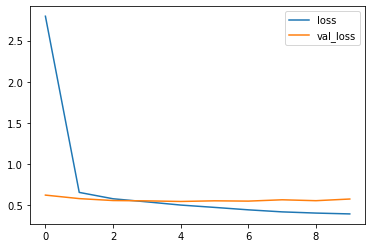

In [ ]:
histDf.plot(y=["loss", "val_loss"])

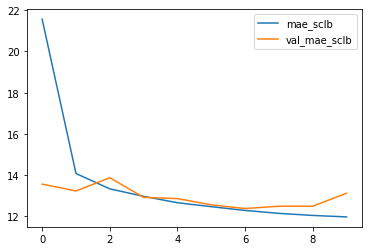

In [ ]:
histDf.plot(y=["mae_sclb", "val_mae_sclb"])

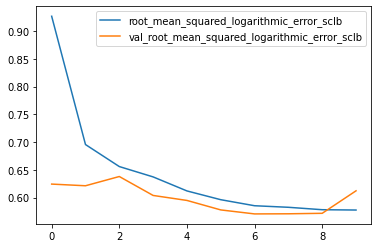

In [ ]:
histDf.plot(y=["root_mean_squared_logarithmic_error_sclb", "val_root_mean_squared_logarithmic_error_sclb"])